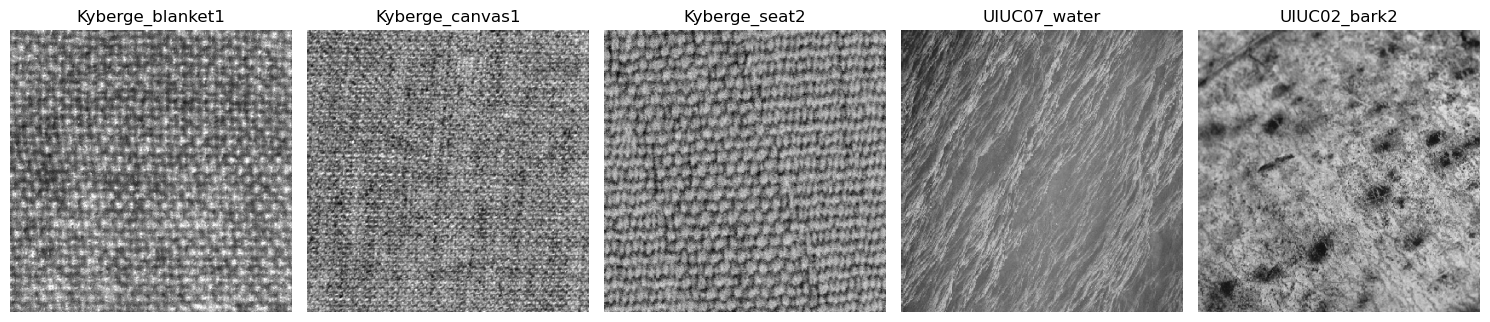

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Set the path to the directory where the dataset is stored
dataset_directory = '/Users/samkhatri/Downloads/Splited/train'

# Initialize a counter for the number of classes processed
num_classes = 0

# Initialize a figure for plotting
plt.figure(figsize=(15, 10))

# Display one image from each class in both vertical and horizontal orientations
for class_name in os.listdir(dataset_directory):
    class_dir = os.path.join(dataset_directory, class_name)
    
    # Check if it's a directory
    if os.path.isdir(class_dir):
        # Get the first image in the directory
        image_name = os.listdir(class_dir)[0]
        image_path = os.path.join(class_dir, image_name)
        
        # Load the image
        image = Image.open(image_path)

        # Increment the class counter
        num_classes += 1

        # Add a subplot for the original image
        plt.subplot(2, 5, num_classes)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')

        # Check if we have processed 5 classes
        if num_classes == 5:
            break

# Adjust subplot parameters for a nicer layout
plt.tight_layout()
plt.show()

In [3]:
#Feature Extraction using a Pre-trained Deep Learning Model:


import torch
import torchvision.transforms as transforms
import torchvision.models as models

# Load pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)
model = model.eval()  # Set the model to evaluation mode

# Define a transform to preprocess the images
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to extract features from an image
def extract_features(image_path):
    image = Image.open(image_path)
    image_tensor = preprocess(image)
    image_tensor = torch.unsqueeze(image_tensor, 0)  # Add batch dimension

    with torch.no_grad():
        features = model(image_tensor)

    return features.numpy().flatten()

# Example: Extract features from an image
example_image_path = '/Users/samkhatri/Downloads/Splited/train/KTH_aluminium_foil/1.jpg'
example_features = extract_features(example_image_path)

/Users/samkhatri/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/samkhatri/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# Similarity Measurement using Cosine Similarity


from sklearn.metrics.pairwise import cosine_similarity

# Function to calculate cosine similarity between two feature vectors
def calculate_similarity(features1, features2):
    features1 = features1.reshape(1, -1)
    features2 = features2.reshape(1, -1)
    similarity = cosine_similarity(features1, features2)
    return similarity[0][0]

# Example: Calculate similarity between two images
image1_path = '/Users/samkhatri/Downloads/Splited/train/KTH_aluminium_foil/1.jpg'
image2_path = '/Users/samkhatri/Downloads/Splited/valid/KTH_aluminium_foil/0.jpg'

features1 = extract_features(image1_path)
features2 = extract_features(image2_path)

similarity = calculate_similarity(features1, features2)
print(f"Cosine Similarity: {similarity:.4f}")

Cosine Similarity: 0.7066


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the CNN architecture
class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 600)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # flatten image input
        x = F.relu(self.fc1(self.dropout(x)))
        x = F.relu(self.fc2(self.dropout(x)))
        x = self.fc3(x)
        return x

custom_net = CustomNet().to(device)


In [10]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Define the path to your custom dataset
custom_dataset_path = '/Users/samkhatri/Downloads/Splited/train'

# Define your transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit ResNet18 input size
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # Normalize with ImageNet mean and standard deviation
])

# Load your custom dataset
custom_dataset = ImageFolder(root=custom_dataset_path, transform=transform)

# Create a DataLoader for your custom dataset
custom_dataloader = DataLoader(custom_dataset, batch_size=64, shuffle=False, num_workers=2)

# Instantiate the pre-trained ResNet18 model
resnet18 = models.resnet18(pretrained=True)
resnet18 = nn.Sequential(*list(resnet18.children())[:-1])  # Remove the last fully connected layer

# Set the model to evaluation mode
resnet18.eval()

# Move the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18.to(device)

# Lists to store extracted features and labels
features = []
labels = []

# Extract features from the custom dataset
with torch.no_grad():
    for data in custom_dataloader:
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)

        # Forward pass to extract features
        feature = resnet18(inputs)
        
        # Append features and labels
        features.append(feature.cpu().numpy())
        labels.append(target.cpu().numpy())

# Concatenate features and labels
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# Now, 'features' contains the extracted features for each image in your custom dataset
# 'labels' contains the corresponding labels for each image


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/samkhatri/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████| 44.7M/44.7M [00:01<00:00, 24.9MB/s]


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np

# Define the path to your custom dataset
custom_dataset_path = '/Users/samkhatri/Downloads/Splited/train'

# Define your transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit ResNet18 input size
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # Normalize with ImageNet mean and standard deviation
])

# Load your custom dataset
custom_dataset = ImageFolder(root=custom_dataset_path, transform=transform)

# Create a DataLoader for your custom dataset
custom_dataloader = DataLoader(custom_dataset, batch_size=64, shuffle=False, num_workers=2)

# Instantiate the pre-trained ResNet18 model
resnet18 = models.resnet18(pretrained=True)
resnet18 = nn.Sequential(*list(resnet18.children())[:-1])  # Remove the last fully connected layer

# Set the model to evaluation mode
resnet18.eval()

# Move the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18.to(device)

# Lists to store extracted features and labels
features = []
labels = []

# Define a hook to store intermediate features
def hook_fn(module, input, output):
    features.append(output.squeeze().cpu().numpy())

# Register the hook to the desired layer (choose an intermediate layer)
intermediate_layer = resnet18[-2][1]  # For ResNet18, the -2 index corresponds to the last convolutional layer
hook = intermediate_layer.register_forward_hook(hook_fn)

# Extract features from the custom dataset
with torch.no_grad():
    for data in custom_dataloader:
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)

        # Forward pass to extract features
        _ = resnet18(inputs)
        labels.append(target.cpu().numpy())

# Remove the hook
hook.remove()

# Concatenate features and labels
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# Display some of the features
num_samples_to_display = 5
for i in range(num_samples_to_display):
    plt.figure(figsize=(8, 8))
    plt.imshow(features[i][0], cmap='viridis')  # Display the feature map
    plt.title(f"Label: {labels[i]}")
    plt.show()